create simple model draft to get outlet embeddings 

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torchmetrics.functional.classification import f1_score
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm 
import random
from sklearn.preprocessing import OneHotEncoder

In [2]:
# load in the news data of interest 
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t") 

<ipython-input-2-e2098ce75a41>:2: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t")


In [3]:
200000*2450000

490000000000

In [4]:
len(df)

2442280

In [5]:
len(df["clustNum"].unique()) 

209415

In [6]:
embeddingsDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/embeddingsKeys.tsv", sep="\t", names=["key", "embedding"], converters={"embedding":lambda x: np.array(x.strip("[]").split(","), dtype=float)})

In [7]:
#we want to get a matrix of outlets x stories 
storyEmbeddings = pd.merge(df[["clustNum", "key"]].dropna(), embeddingsDf, on="key", how="left") 

In [8]:
storyEmbeddings = storyEmbeddings.drop(columns=["key"]).groupby("clustNum").agg([np.mean, len])

In [9]:
storyEmbeddings.columns = storyEmbeddings.columns.droplevel()

In [10]:
storyEmbeddings = storyEmbeddings[storyEmbeddings["len"] < 3000].reset_index() 

In [11]:
storyEmbeddings = storyEmbeddings.rename(columns={"mean":"storyMean", "len":"clustSize"}) 

In [12]:
#we give a story cluster number and get back the average embedding for that story cluster 
storyDict = storyEmbeddings.set_index("clustNum")[["storyMean"]].to_dict()["storyMean"] 

In [15]:
#we want to get a list of all possible story clusters that an outlet can cover
allClusts = storyEmbeddings["clustNum"].tolist()

In [133]:
#keep only the articles that we have embeddings for, since we removed some clusters above
outletStoryDf = df.loc[df["clustNum"].isin(allClusts), ["source", "clustNum"]]

In [134]:
#now we have each outlet and stories it covered 
outletStoryDf = outletStoryDf.drop_duplicates()

In [135]:
clusteredStories = outletStoryDf.groupby("source").agg(set)
clusteredStories["covered"] = 1

notCoveredSamples = [] 
i = 0 
for source, currStories in tqdm(clusteredStories.iterrows()): 
    # we get the stories not covered by this outlet 
    # simply all stories minus the stories this outlet did cover 
    currStories = currStories["clustNum"]
    notCovered = set(allClusts) - currStories
    
    #take 1 times as many negative examples as positive 
    sample = random.sample(list(notCovered), 1 * len(currStories))
    notCoveredSamples.append((source, sample)) 

787it [00:09, 84.32it/s]


In [136]:
notCoveredDf = pd.DataFrame(notCoveredSamples, columns=["source", "clustNum"])
notCoveredDf["covered"] = 0

In [138]:
#get outlet level information 
outletDf = df[["source", "state"]].drop_duplicates().fillna("National")

In [139]:
#stateArray = np.array([[item] for item in outletDf["state"]]) 

In [140]:
"""
# one hot encode our states 
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(stateArray)
onehot_encoded.shape

#make one hot encoded vector a column in our dataframe 
outletDf["hotState"] = list(onehot_encoded)
"""

'\n# one hot encode our states \nonehot_encoder = OneHotEncoder(sparse=False)\nonehot_encoded = onehot_encoder.fit_transform(stateArray)\nonehot_encoded.shape\n\n#make one hot encoded vector a column in our dataframe \noutletDf["hotState"] = list(onehot_encoded)\n'

In [141]:
clusteredStories = clusteredStories.reset_index().explode("clustNum")
notCoveredDf = notCoveredDf.explode("clustNum") 

In [142]:
#a long form dataframe that gives us outlet, story cluster num, covered or not
allCoverage = pd.concat([notCoveredDf.reset_index(drop=True), clusteredStories.reset_index(drop=True)],axis=0) 

In [145]:
#merge our one hot encoded vectors into the allCoverage dataframe 
allCoverage = pd.merge(allCoverage, outletDf[["source", "state"]], on="source", how="left") 

In [147]:
# mix up the rows so that we have equal number of pos/neg training examples 
allCoverage = allCoverage.sample(frac = 1) 

In [148]:
allCoverage.head()

,source,clustNum,covered,state
1164864,thetorontostar,100403.0,1,National
1128017,theseattletimes,4108.0,1,National
806667,hotair,2814.0,1,National
101685,dailyguide,147740.0,0,Missouri
867911,nationalinterest,97273.0,1,National


In [149]:
### beginning of code for model training ###

In [150]:
deviceNum = 2
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [216]:
class BasicModel(nn.Module):

    def __init__(self, numOutlets, storyVecLen, numStates, stateEmbedLen, storyDict):
        super(BasicModel, self).__init__()
        self.outletEmbeddings = nn.Embedding(numOutlets, storyVecLen)
        self.stateEmbeddings = nn.Embedding(numStates, stateEmbedLen)
        self.storyDict = storyDict
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout()
        self.linear1 = nn.Linear((storyVecLen * 2) + stateEmbedLen, 200)
        self.linear2 = nn.Linear(200, 1) 
    
    #input will be the indices of the embeddings 
    def forward(self, outletIds, stateIds, storyVecIds):
        #these are the outlet/state embeddings we are learning
        #NOT the fixed story embeddings 
        outletEmbeds = self.outletEmbeddings(outletIds) #.view((1, -1))
        stateEmbeds = self.stateEmbeddings(stateIds)
        
        storyVecs = torch.tensor([self.storyDict[int(clustNum)] for clustNum in storyVecIds], dtype=torch.float32).to(device)
        inTens = torch.concat((stateEmbeds, outletEmbeds, storyVecs), dim=1).to(device)
              
        out = self.ReLU(self.Dropout(self.linear1(inTens)))
        out = self.linear2(out)
        probs = self.Sigmoid(out)
        return probs
        

In [217]:
dataset = Dataset.from_pandas(allCoverage.head(2000000))
trainDataset, validDataset = random_split(dataset, [.9, .1]) 

In [218]:
df["state"] = df["state"].fillna("National")

In [219]:
#get each outlet and state a unique index 
#we then use this index to recover their embeddings from our matrix 
outlets = df["source"].unique()
outletDict = {outlets[i]:i for i in range(0, len(outlets))}

states = df["state"].unique()
stateDict = {states[i]:i for i in range(0, len(states))}

In [220]:
numStates = len(states) 
model = BasicModel(len(outlets), 768, numStates, 47, storyDict) 

#make sure everything is on device 
model.to(device)

BasicModel(
  (outletEmbeddings): Embedding(829, 768)
  (stateEmbeddings): Embedding(47, 47)
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
  (Dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1583, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=1, bias=True)
)

In [221]:
TRAIN_BATCH_SIZE=100
VALID_BATCH_SIZE=300
EPOCHS=1

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=.0001)
#optim = torch.optim.SGD(model.parameters(), lr=0.001)
# and setup a warmup for the first ~10% steps
total_steps = int((len(trainDataset) * EPOCHS) / TRAIN_BATCH_SIZE)
warmup_steps = int(0.1 * total_steps)
#warmup_steps = 0 
#TODO: change warmup steps back after 
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

loss_func = torch.nn.BCELoss()

trainLoader = DataLoader(trainDataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [222]:
trainDataset[0]

{'source': 'thebrainerddailydispatch',
 'clustNum': 149808.0,
 'covered': 0,
 'state': 'Minnesota',
 '__index_level_0__': 366029}

In [223]:
len(trainDataset) / TRAIN_BATCH_SIZE

11349.27

In [224]:
def validate(): 
    #validation loop 
    allPreds = []
    allGts = []
    for batch in validLoader: 
        outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
        stateLookups = torch.tensor([stateDict[state] for state in batch["state"]]).to(device)
        preds = model(outletLookups, stateLookups, batch["clustNum"].to(device))
        gts = torch.unsqueeze(batch["covered"], dim=1).to(device) 
        allPreds += preds.detach().squeeze().cpu().tolist()
        allGts += gts.detach().squeeze().cpu().tolist()
    return f1_score(torch.tensor(allPreds), torch.tensor(allGts)) 


In [225]:
#f1_score(torch.tensor(preds), torch.tensor(gts))

In [226]:
model.parameters

<bound method Module.parameters of BasicModel(
  (outletEmbeddings): Embedding(829, 768)
  (stateEmbeddings): Embedding(47, 47)
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
  (Dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1583, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=1, bias=True)
)>

In [227]:
print(model.linear1._parameters['weight'].detach()[0, :100])
#print(model.embeddings.weight[0].detach().tolist()[:20])
#print(model.embeddings.weight[30].detach().tolist()[:20])

tensor([ 0.0196,  0.0191, -0.0242,  0.0012,  0.0190, -0.0240, -0.0014,  0.0033,
        -0.0232, -0.0060, -0.0111, -0.0203,  0.0164, -0.0140,  0.0141, -0.0181,
        -0.0109,  0.0240,  0.0156,  0.0083, -0.0093, -0.0049, -0.0135, -0.0032,
        -0.0038, -0.0146,  0.0199, -0.0164,  0.0183, -0.0027,  0.0220,  0.0107,
        -0.0141,  0.0003,  0.0180, -0.0138, -0.0131,  0.0248, -0.0001, -0.0140,
        -0.0119, -0.0077,  0.0245, -0.0206, -0.0059,  0.0207,  0.0181,  0.0029,
        -0.0242,  0.0059, -0.0106, -0.0242, -0.0123, -0.0157,  0.0183, -0.0202,
         0.0090, -0.0200,  0.0191, -0.0150,  0.0159, -0.0009,  0.0038,  0.0154,
         0.0183, -0.0076, -0.0215,  0.0218,  0.0131,  0.0135,  0.0216, -0.0102,
        -0.0080, -0.0214, -0.0154, -0.0041,  0.0205,  0.0060,  0.0239, -0.0179,
        -0.0068, -0.0250,  0.0154, -0.0241, -0.0214,  0.0029, -0.0099, -0.0094,
        -0.0139,  0.0109,  0.0181, -0.0173,  0.0003,  0.0049, -0.0208,  0.0048,
         0.0166, -0.0107, -0.0029,  0.01

In [228]:
[param.size() for param in model.parameters()]

[torch.Size([829, 768]),
 torch.Size([47, 47]),
 torch.Size([200, 1583]),
 torch.Size([200]),
 torch.Size([1, 200]),
 torch.Size([1])]

In [229]:
model.train()
validTups = []
lossList = []
subLossList = []
i = 0 
for batch in tqdm(trainLoader): 
    model.train()
    optim.zero_grad()
    #print(f"grad before updating\n {model.linear1.weight.grad[0, :10]}") 
    if i % 100 == 0: 
        #print(model.linear1._parameters['weight'].detach())
        pass
        
    #use matrix to lookup instead of dictionary 
    #get the outlet ids from the outlet names fed into lookup dictionary  
    outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
    stateLookups = torch.tensor([stateDict[state] for state in batch["state"]]).to(device)
    #get the embeddings using the id corresponding to each outlet 
    #outletEmbeds = embeds(outletLookups)
    
    preds = model(outletLookups, stateLookups, batch["clustNum"].to(device))
    
    #each story cluster has an id, get the embedding id from the story cluster-embedding dictionary using this id
    #storyEmbeds = torch.tensor([embeddingsDict[int(clustNum)] for clustNum in batch["clustNum"]], dtype=torch.float32)
    
    #get ground truth labels from the batch 
    gts = torch.unsqueeze(batch["covered"], dim=1).type("torch.FloatTensor").to(device) 
    
    #concatenate the outlet embedding and story cluster BERT embedding 
    #inTens = torch.concat((outletEmbeds, storyEmbeds), dim=1).to(device)
    
    #preds = model(inTens)
    loss = loss_func(preds, gts)
    loss.backward()
    optim.step()
    #for item in optim.param_groups: 
    #    print(item['lr']) 
    #print(f"grad after updating \n{model.linear1.weight.grad[0,:10]}")  
    scheduler.step()
    subLossList.append(loss.detach().item())
    if i % 2000 == 0:
        model.eval()
        #print(validate())
        validTups.append((validate()))
        lossList.append(np.mean(subLossList))
        subLossList = []
        model.train()
    i += 1

100%|██████████| 11350/11350 [03:17<00:00, 57.33it/s] 


In [230]:
#model.linear2.weight.grad[0]

In [231]:
print(model.linear1._parameters['weight'].detach()[1])

tensor([ 0.0220, -0.0053,  0.0220,  ..., -0.0157,  0.0385, -0.0468],
       device='cuda:2')


In [232]:
"""
print(model.linear1._parameters['weight'].detach())
print(model.embeddings.weight[0].detach().tolist()[:20])
print(model.embeddings.weight[30].detach().tolist()[:20])
"""

"\nprint(model.linear1._parameters['weight'].detach())\nprint(model.embeddings.weight[0].detach().tolist()[:20])\nprint(model.embeddings.weight[30].detach().tolist()[:20])\n"

In [233]:
validDf = pd.DataFrame(validTups, columns=["f1"])

In [234]:
#validDf

(array([3., 0., 1., 1., 2., 3., 4., 4., 4., 5.]),
 array([0.09861594, 0.17118576, 0.24375557, 0.31632538, 0.38889519,
        0.461465  , 0.53403481, 0.60660462, 0.67917444, 0.75174425,
        0.82431406]),
 <BarContainer object of 10 artists>)

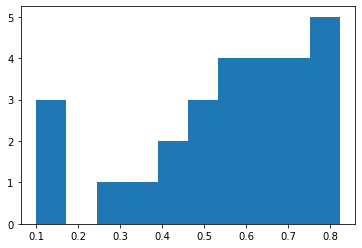

In [235]:
plt.hist(preds.squeeze().tolist()) 

(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

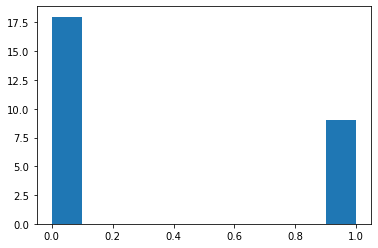

In [239]:
plt.hist(gts.squeeze().tolist())

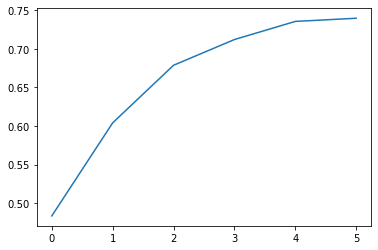

In [236]:
plt.plot([i for i in range(len(validTups))],validDf["f1"])

In [237]:
#preds

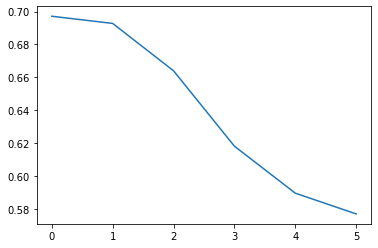

In [238]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(0, len(lossList))], lossList) 

In [278]:
torch.concat((outletEmbeds, storyEmbeds), dim=1).size()

torch.Size([2, 1536])

In [289]:
torch.preds

tensor([[0.4718],
        [0.4707]], grad_fn=<SigmoidBackward0>)

In [291]:
torch.squeeze(preds)

tensor([0.4718, 0.4707], grad_fn=<SqueezeBackward0>)

In [296]:
torch.unsqueeze(batch["covered"], dim=1)

tensor([[0],
        [0]])